In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# API / Web Scraping

In [3]:
api_url = 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37'
valid = requests.get(api_url)

if valid.status_code == 200:
    data = valid.json()
    print('Valid API')
else:
    print(f"Error: {valid.status_code}")

Valid API


In [4]:
api_key = 'aquafox27'
api_url = 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37'  # Replace with the actual API endpoint
headers = {'api_key': api_key}  
response = requests.get(api_url, headers=headers)
if response.status_code == 200:
    data = response.json()
else:
    print(f'Error: {response.status_code}')
    print(response.text)

In [5]:
response

<Response [200]>

In [6]:
data

{'Header': [{'status': 'Success',
   'request_time': '2024-03-05T19:10:56-05:00',
   'url': 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37',
   'rows': 27}],
 'Data': [{'state_code': '37',
   'county_code': '021',
   'site_number': '0032',
   'parameter_code': '45201',
   'poc': 1,
   'latitude': 35.558333,
   'longitude': -82.520833,
   'datum': 'WGS84',
   'parameter': 'Benzene',
   'sample_duration_code': '3',
   'sample_duration': '4 HOUR',
   'pollutant_standard': None,
   'metric_used': 'Observed Values',
   'method': '6L PRESSURIZED CANISTER - DUAL FID - PAMS',
   'year': 1995,
   'units_of_measure': 'Parts per billion Carbon',
   'event_type': 'No Events',
   'observation_count': 10,
   'observation_percent': 3.0,
   'validity_indicator': 'N',
   'valid_day_count': 0,
   'required_day_count': 54,
   'exceptional_data_count': 0,
   'null_observation_count': 0,
   'primary_exceedance_count': None,
  

In [7]:
df = pd.DataFrame(data['Data'])
df.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,fiftieth_percentile,tenth_percentile,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,37,021,0032,45201,1,35.558333,-82.520833,WGS84,Benzene,3,...,7.7,1.8,None,LONDON RD ASHVILLE NC 28803,North Carolina,Buncombe,Asheville,11700,"Asheville, NC",2020-05-21
1,37,077,0001,45201,1,36.141111,-78.768056,WGS84,Benzene,B,...,2.0,1.3,Butner,800 Central Avenue,North Carolina,Granville,Butner,37080,"Oxford, NC",2020-05-21
2,37,119,0034,45201,1,35.248754,-80.766181,WGS84,Benzene,B,...,6.0,2.1,None,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
3,37,119,0034,45201,2,35.248754,-80.766181,WGS84,Benzene,3,...,6.4,1.7,None,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
4,37,159,0022,45201,1,35.534482,-80.667560,WGS84,Benzene,3,...,2.7,1.0,Enochville School,925 N ENOCHVILLE AVE,North Carolina,Rowan,China Grove,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21


In [8]:
df.to_excel('WEATHER.xlsx', index=False, encoding="UTF-8")

C:\Users\choks\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


# Data Cleaning

In [9]:
columns_to_drop = ["pollutant_standard", "valid_day_count", "validity_indicator", "exceptional_data_count", "null_observation_count", "primary_exceedance_count", "secondary_exceedance_count", "certification_indicator", "first_max_nonoverlap_value", "first_max_n_o_datetime", "second_max_nonoverlap_value", "second_max_n_o_datetime", "local_site_name"]
df = df.drop(columns=columns_to_drop, axis=1)

In [10]:
df.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,seventy_fifth_percentile,fiftieth_percentile,tenth_percentile,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,37,021,0032,45201,1,35.558333,-82.520833,WGS84,Benzene,3,...,8.0,7.7,1.8,LONDON RD ASHVILLE NC 28803,North Carolina,Buncombe,Asheville,11700,"Asheville, NC",2020-05-21
1,37,077,0001,45201,1,36.141111,-78.768056,WGS84,Benzene,B,...,2.9,2.0,1.3,800 Central Avenue,North Carolina,Granville,Butner,37080,"Oxford, NC",2020-05-21
2,37,119,0034,45201,1,35.248754,-80.766181,WGS84,Benzene,B,...,7.9,6.0,2.1,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
3,37,119,0034,45201,2,35.248754,-80.766181,WGS84,Benzene,3,...,14.6,6.4,1.7,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
4,37,159,0022,45201,1,35.534482,-80.667560,WGS84,Benzene,3,...,3.6,2.7,1.0,925 N ENOCHVILLE AVE,North Carolina,Rowan,China Grove,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21


In [11]:
df.isnull().any()

state_code                  False
county_code                 False
site_number                 False
parameter_code              False
poc                         False
latitude                    False
longitude                   False
datum                       False
parameter                   False
sample_duration_code        False
sample_duration             False
metric_used                 False
method                      False
year                        False
units_of_measure            False
event_type                  False
observation_count           False
observation_percent         False
required_day_count          False
arithmetic_mean             False
standard_deviation          False
first_max_value             False
first_max_datetime          False
second_max_value            False
second_max_datetime         False
third_max_value             False
third_max_datetime          False
fourth_max_value            False
fourth_max_datetime         False
ninety_ninth_p

In [12]:
df.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
metric_used                 0
method                      0
year                        0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
required_day_count          0
arithmetic_mean             0
standard_deviation          0
first_max_value             0
first_max_datetime          0
second_max_value            0
second_max_datetime         0
third_max_value             0
third_max_datetime          0
fourth_max_value            0
fourth_max_datetime         0
ninety_ninth_percentile     0
ninety_eighth_percentile    0
ninety_fifth_percentile     0
ninetieth_percentile        0
seventy_fi

In [13]:
dfc = df.dropna()

In [14]:
dfc.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
metric_used                 0
method                      0
year                        0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
required_day_count          0
arithmetic_mean             0
standard_deviation          0
first_max_value             0
first_max_datetime          0
second_max_value            0
second_max_datetime         0
third_max_value             0
third_max_datetime          0
fourth_max_value            0
fourth_max_datetime         0
ninety_ninth_percentile     0
ninety_eighth_percentile    0
ninety_fifth_percentile     0
ninetieth_percentile        0
seventy_fi

In [15]:
dfc.head()  #cleaned dataset

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,seventy_fifth_percentile,fiftieth_percentile,tenth_percentile,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,37,021,0032,45201,1,35.558333,-82.520833,WGS84,Benzene,3,...,8.0,7.7,1.8,LONDON RD ASHVILLE NC 28803,North Carolina,Buncombe,Asheville,11700,"Asheville, NC",2020-05-21
1,37,077,0001,45201,1,36.141111,-78.768056,WGS84,Benzene,B,...,2.9,2.0,1.3,800 Central Avenue,North Carolina,Granville,Butner,37080,"Oxford, NC",2020-05-21
2,37,119,0034,45201,1,35.248754,-80.766181,WGS84,Benzene,B,...,7.9,6.0,2.1,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
3,37,119,0034,45201,2,35.248754,-80.766181,WGS84,Benzene,3,...,14.6,6.4,1.7,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
4,37,159,0022,45201,1,35.534482,-80.667560,WGS84,Benzene,3,...,3.6,2.7,1.0,925 N ENOCHVILLE AVE,North Carolina,Rowan,China Grove,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21


In [16]:
dfc.to_excel('WEATHERMAIN.xlsx', index=False, encoding="UTF-8")

C:\Users\choks\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


# Exploratory Data Analysis / Data Visualization

In [17]:
dfc.describe()

,poc,latitude,longitude,year,observation_count,observation_percent,required_day_count,arithmetic_mean,standard_deviation,first_max_value,second_max_value,third_max_value,fourth_max_value,ninety_ninth_percentile,ninety_eighth_percentile,ninety_fifth_percentile,ninetieth_percentile,seventy_fifth_percentile,fiftieth_percentile,tenth_percentile
count,21.000000,21.000000,21.000000,21.0,21.00000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.190476,35.748069,-79.446518,1995.0,23.00000,2.142857,210.666667,5.226633,3.311908,13.642857,10.733333,9.080952,8.038095,13.642857,13.642857,12.161905,9.652381,7.285714,4.757143,1.995238
std,0.402374,0.314859,1.306930,0.0,10.81203,1.276155,128.274445,2.874095,1.757624,6.254244,5.437401,5.320490,4.829024,6.254244,6.254244,5.881962,5.729277,4.702689,2.798852,1.656042
min,1.000000,35.029403,-82.520833,1995.0,6.00000,1.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,35.558333,-80.667560,1995.0,12.00000,1.000000,88.000000,2.960870,2.106322,8.000000,6.000000,4.600000,4.000000,8.000000,8.000000,7.900000,4.700000,3.600000,2.600000,1.200000
50%,1.000000,35.774875,-78.904167,1995.0,22.00000,2.000000,213.000000,4.386486,3.546191,14.800000,10.600000,8.800000,7.600000,14.800000,14.800000,13.400000,9.100000,5.500000,4.200000,1.700000
75%,1.000000,36.035556,-78.635190,1995.0,33.00000,3.000000,365.000000,7.570833,4.075894,17.800000,14.600000,12.700000,11.600000,17.800000,17.800000,15.700000,14.600000,11.500000,6.600000,2.100000
max,2.000000,36.141111,-77.368298,1995.0,41.00000,5.000000,365.000000,10.287879,7.459207,25.800000,20.400000,20.000000,16.800000,25.800000,25.800000,25.800000,20.000000,15.600000,10.800000,6.100000


In [18]:
benzenestats = dfc['arithmetic_mean'].describe()
print(benzenestats)


count    21.000000
mean      5.226633
std       2.874095
min       0.000000
25%       2.960870
50%       4.386486
75%       7.570833
max      10.287879
Name: arithmetic_mean, dtype: float64


C:\Users\choks\AppData\Local\Temp\ipykernel_64508\1282773394.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


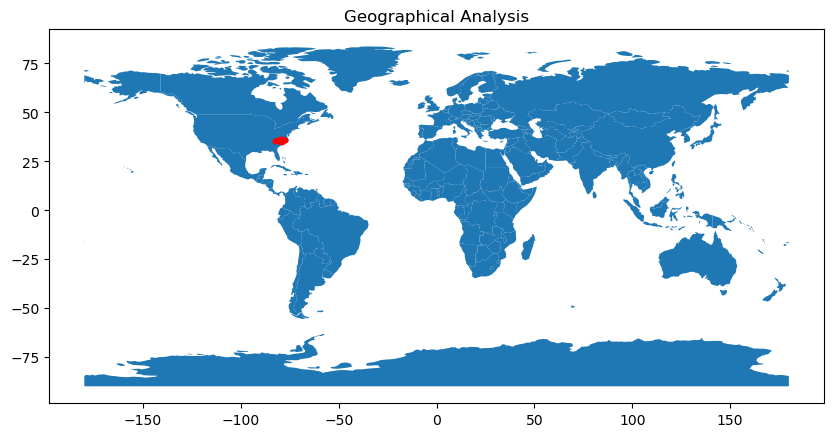

In [19]:
geom = [Point(xy) for xy in zip(dfc['longitude'], dfc['latitude'])]
gdfc = gpd.GeoDataFrame(dfc, geometry=geom)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
gdfc.plot(ax=ax, color='red', marker='o', markersize=10)
plt.title('Geographical Analysis')
plt.show()


The whole dataset is based on a country code 37, which corresponds to North Carolina, the above plot shows the region where the data is taken from, for the air quality measurements of the benzene levels.

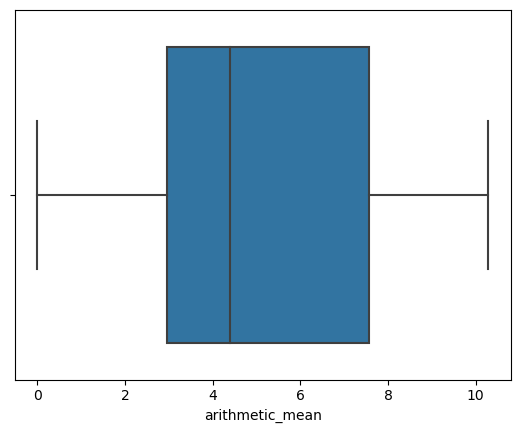

In [20]:
sns.boxplot(x=dfc['arithmetic_mean'])
plt.show()


The above plot is used to show the outlier detection and it can be seen that there are not any outliers in the dataset.

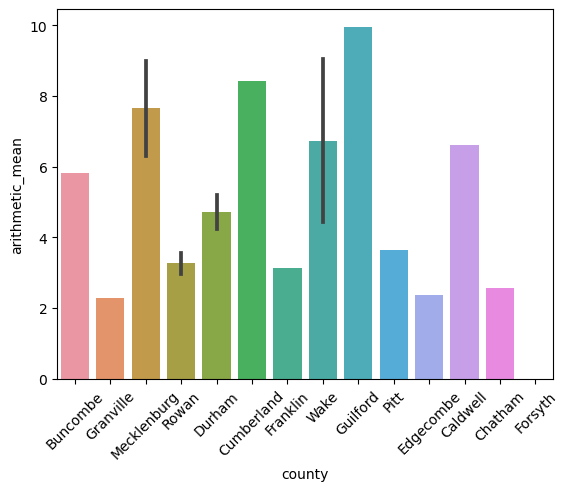

In [21]:
sns.barplot(x='county', y='arithmetic_mean', data=dfc)
plt.xticks(rotation=45)
plt.show()

The arithmetic mean here is a parameter (air quality measurement) for different counties in the state of North Carolina. 

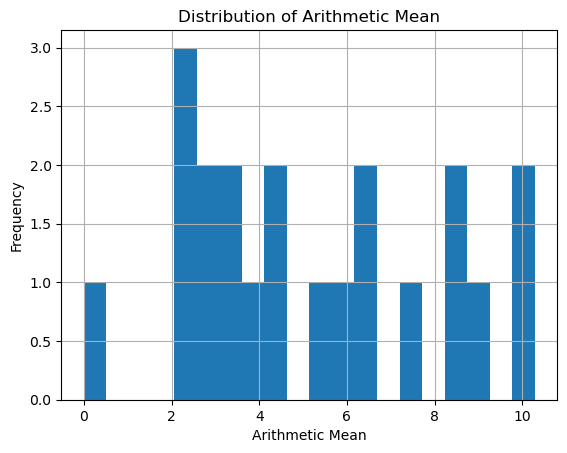

In [22]:
dfc['arithmetic_mean'].hist(bins=20)
plt.title('Distribution of Arithmetic Mean')
plt.xlabel('Arithmetic Mean')
plt.ylabel('Frequency')
plt.show()

The above plot shows the percentage of to what level the benzene levels fall in the air quality measurements in the state of North carolina.

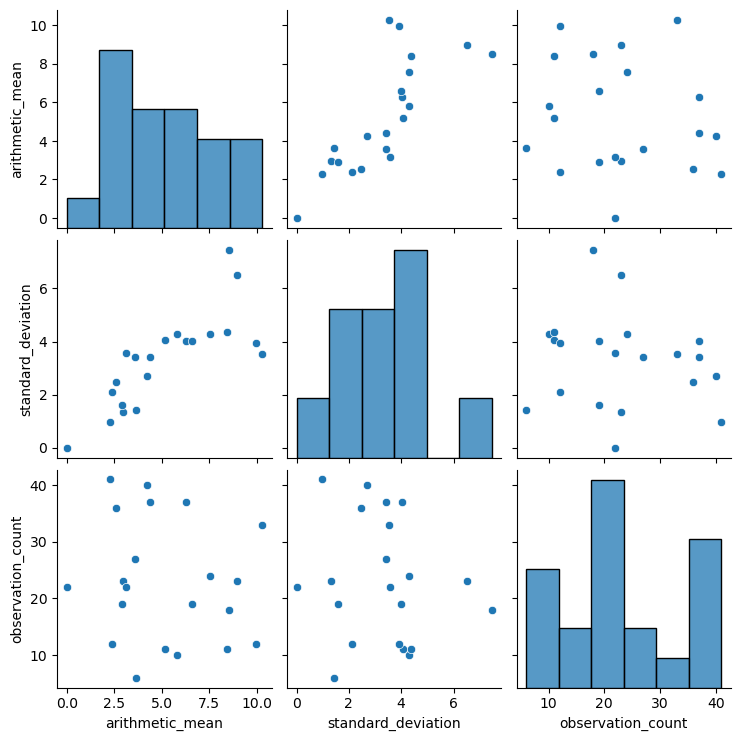

In [23]:
sns.pairplot(dfc[['arithmetic_mean', 'standard_deviation', 'observation_count']])
plt.show()

The above pairplot provides a summary of the relationships between the arithmetic mean, standard deviation and the observation count of the benzene levels.

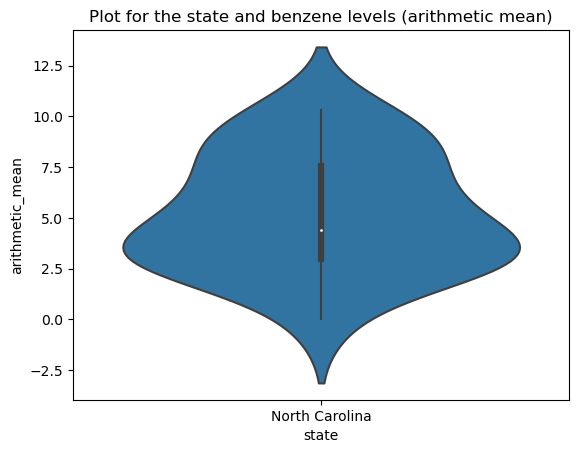

In [24]:
sns.violinplot(x='state', y='arithmetic_mean', data=dfc)
plt.title('Plot for the state and benzene levels (arithmetic mean)')
plt.show()

The above plot helps in understanding the skewness and central tendency of the spread of distribution in the state.

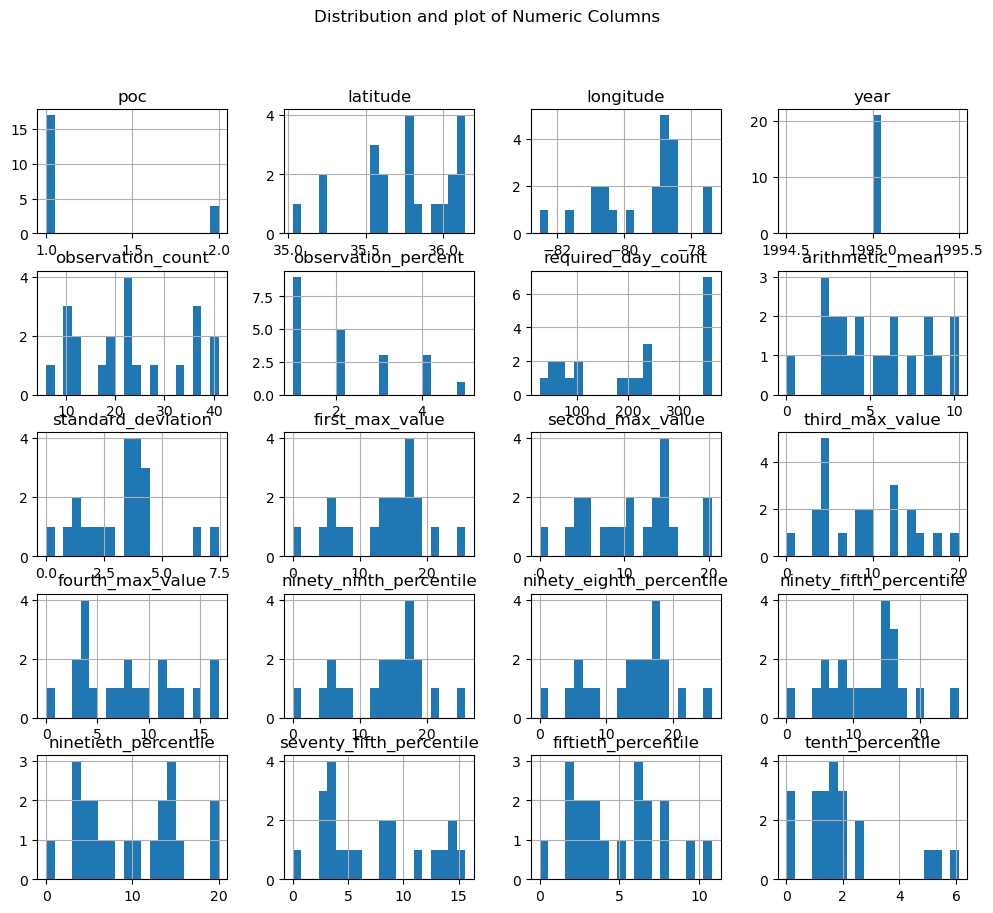

In [25]:
dfc.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution and plot of Numeric Columns')
plt.show()

The above plot is used to show the patterns and distribution of numeric values in the dataset.

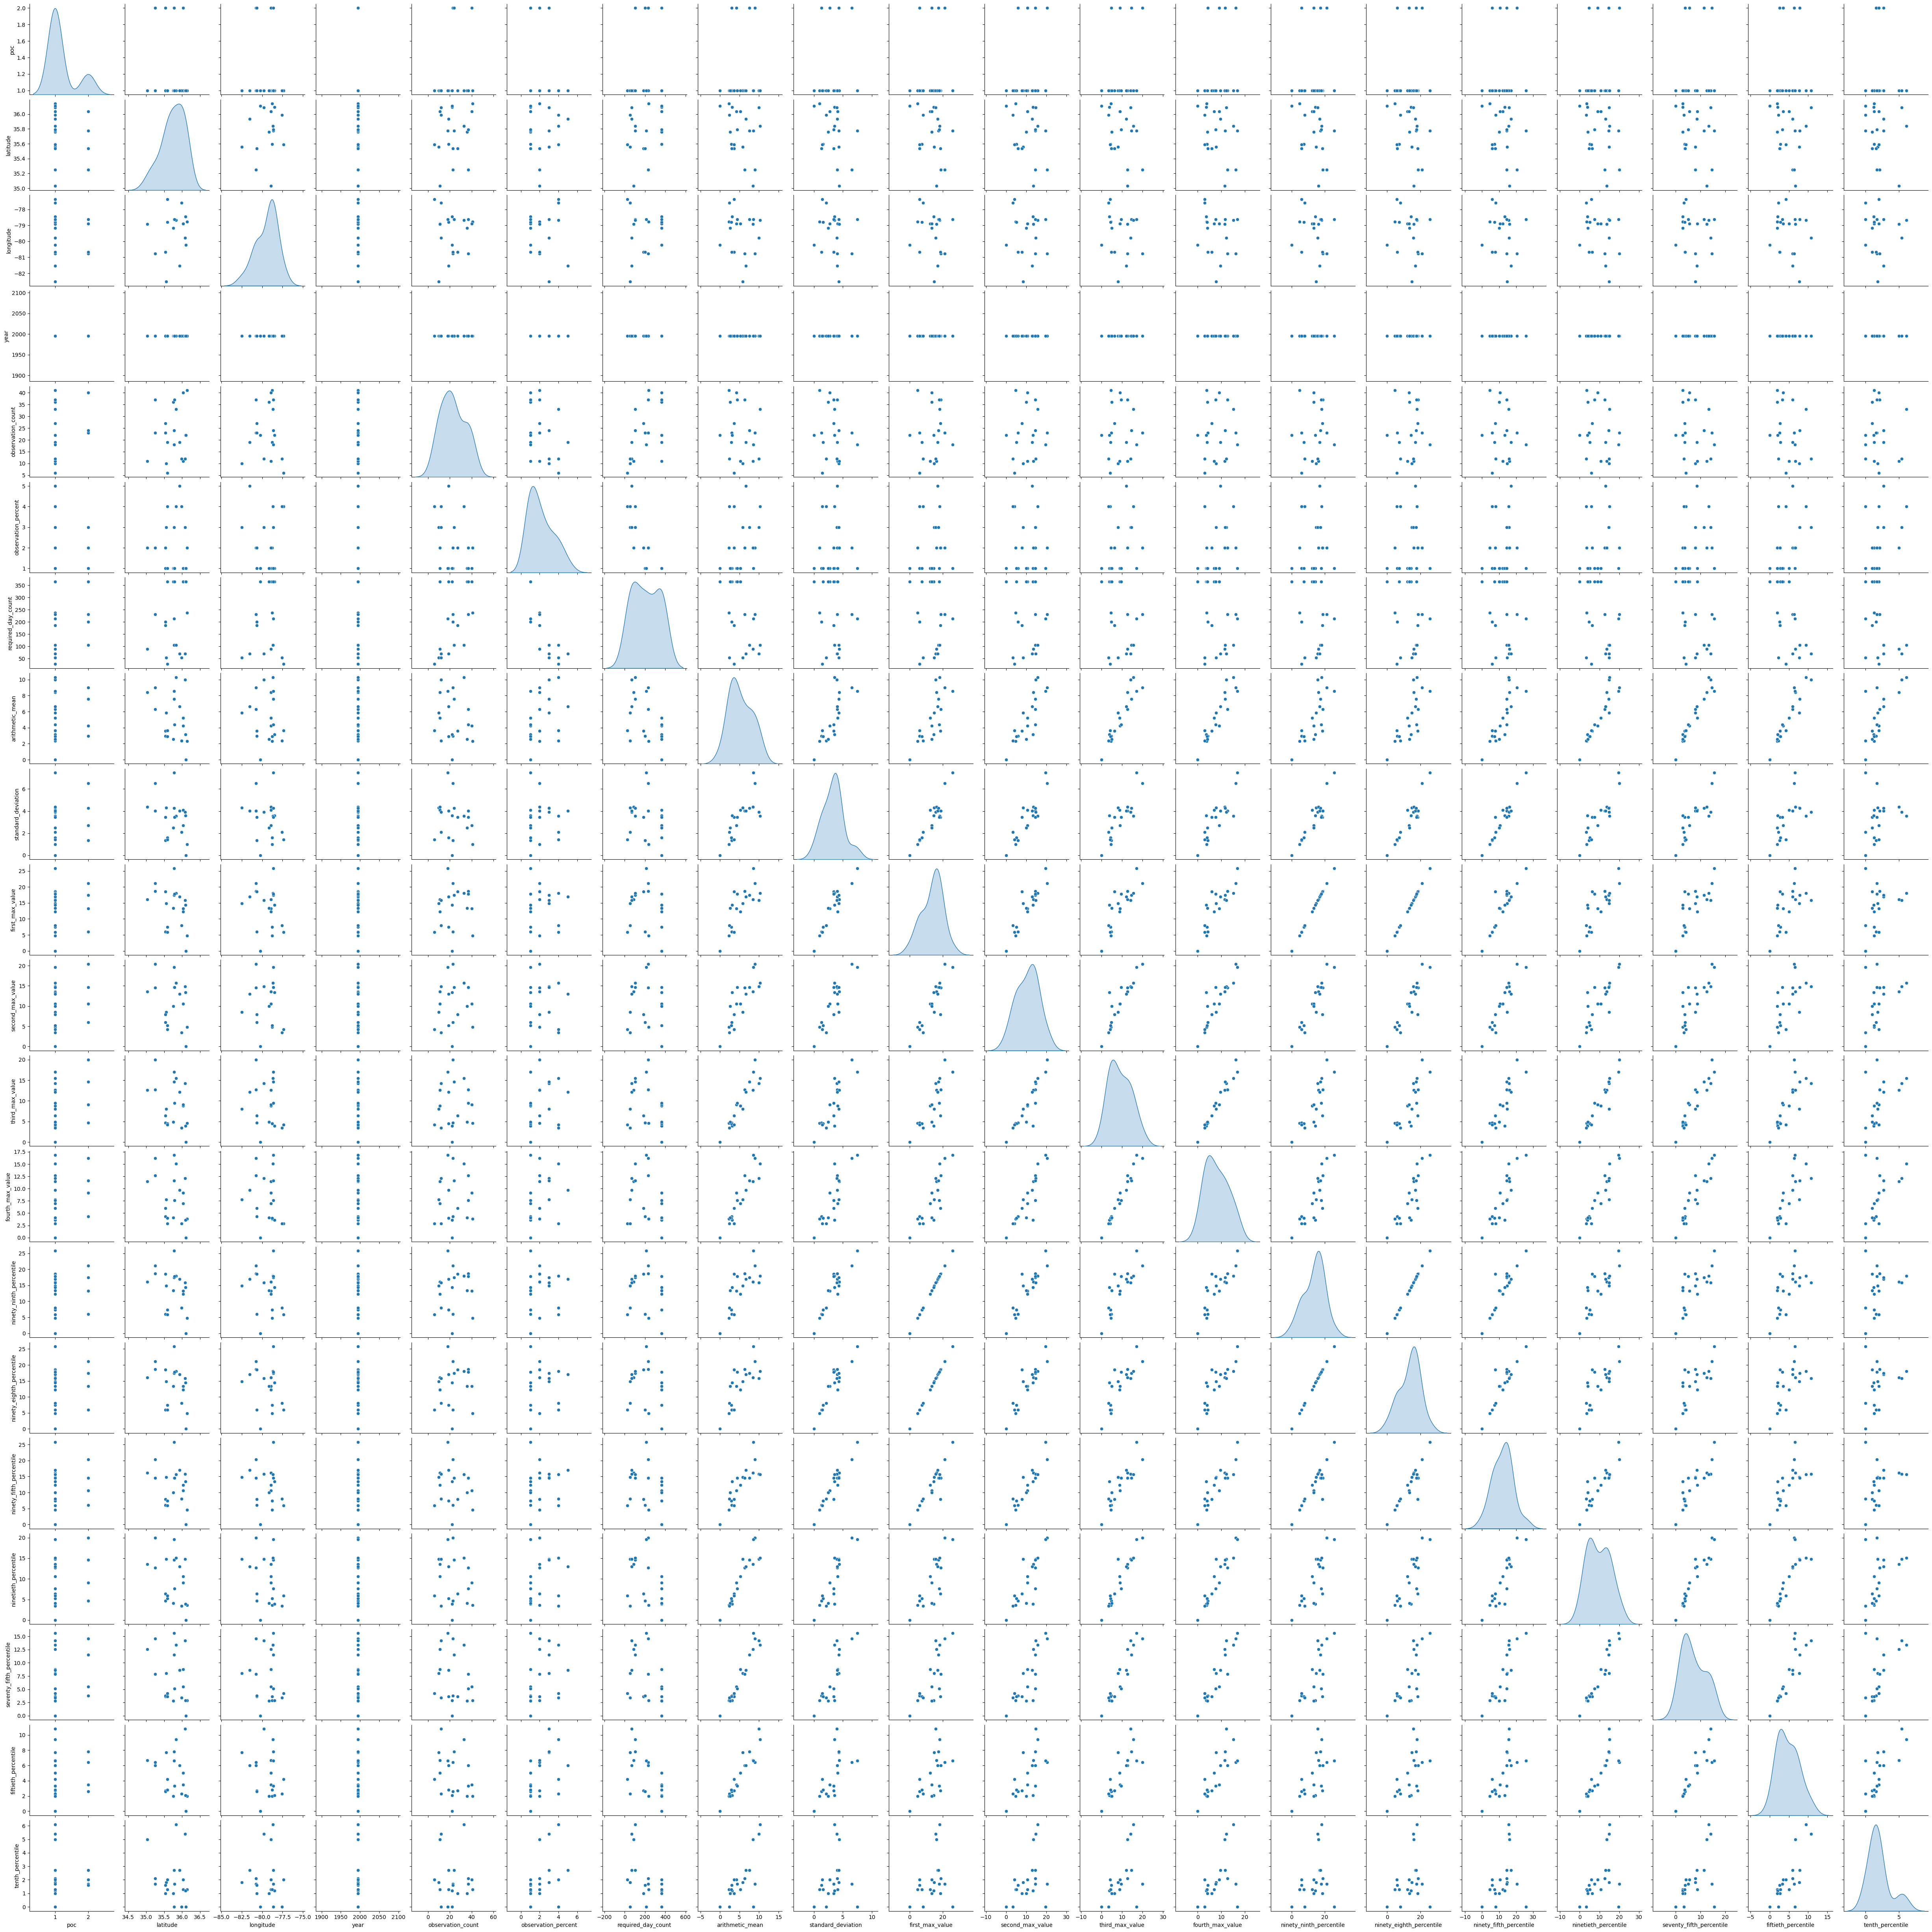

In [26]:
sns.pairplot(dfc, diag_kind='kde')
plt.show()

The above is used to show the relationship between the variables of the dataframe.

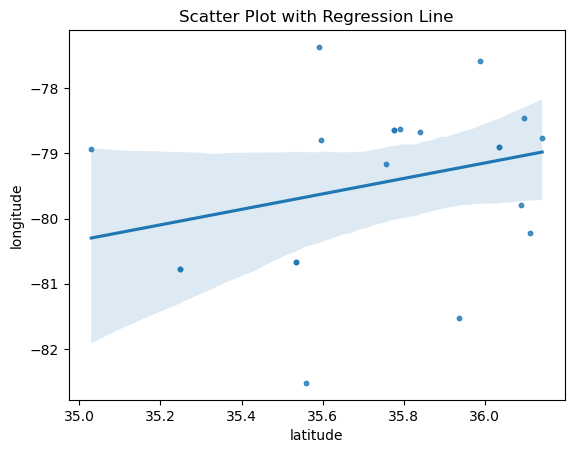

In [27]:
sns.regplot(x='latitude', y='longitude', data=dfc, scatter_kws={'s':10})
plt.title('Scatter Plot with Regression Line')
plt.show()

Since there is a positive correlation depicted in the plot, which suggests that as the latitude and longitude increases the benzene levels do increase too in the state of North Carolina

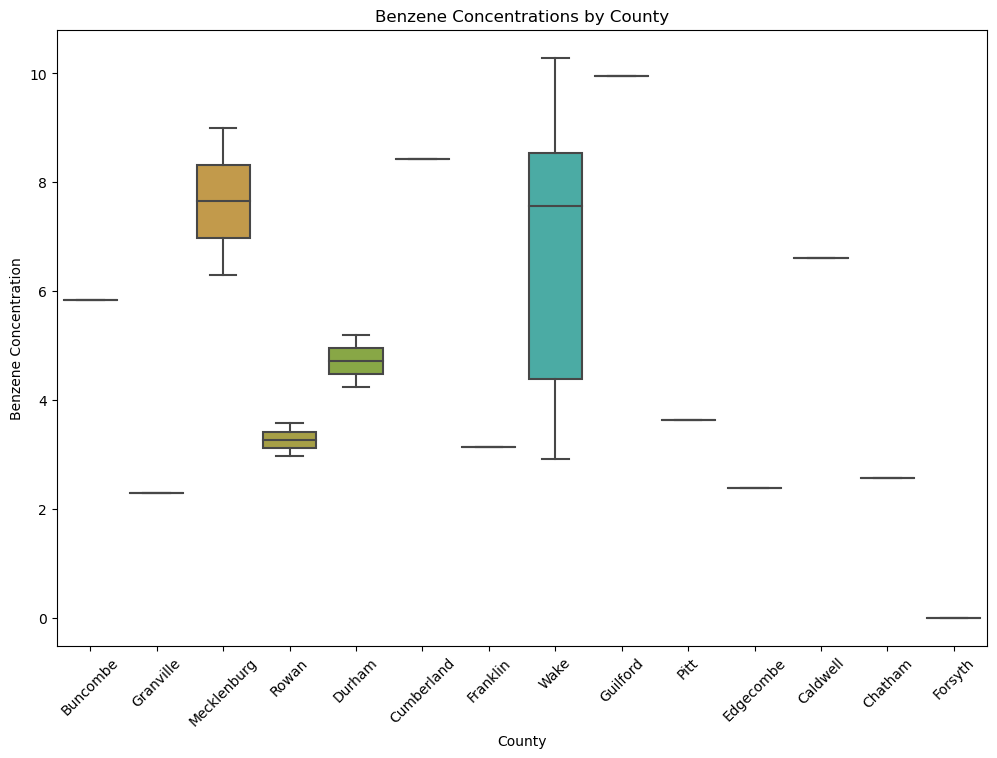

In [28]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='county', y='arithmetic_mean', data=dfc)
plt.title('Benzene Concentrations by County')
plt.xlabel('County')
plt.ylabel('Benzene Concentration')
plt.xticks(rotation=45)
plt.show()


The above plot shows the distribution of benzene level in the air of different counties of the state of North Carolina.

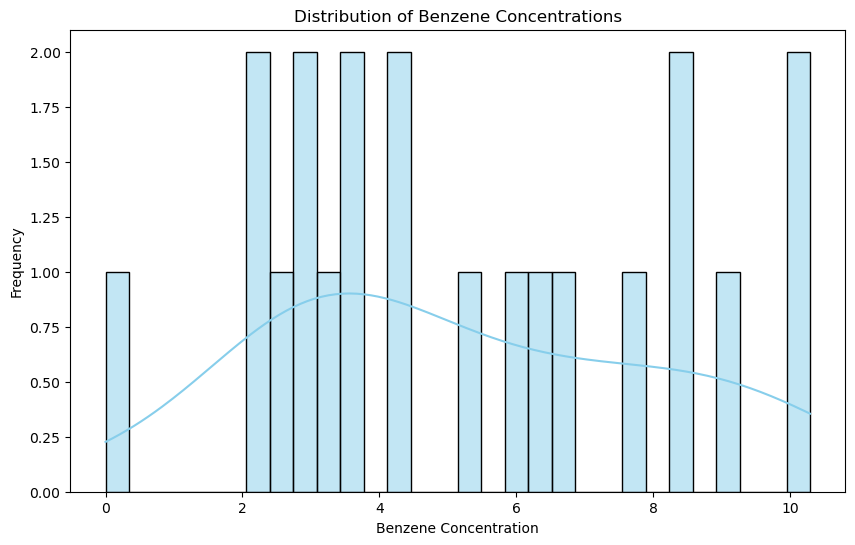

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(dfc['arithmetic_mean'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Benzene Concentrations')
plt.xlabel('Benzene Concentration')
plt.ylabel('Frequency')
plt.show()

The above plot shows the average distribtuion of benzene levels

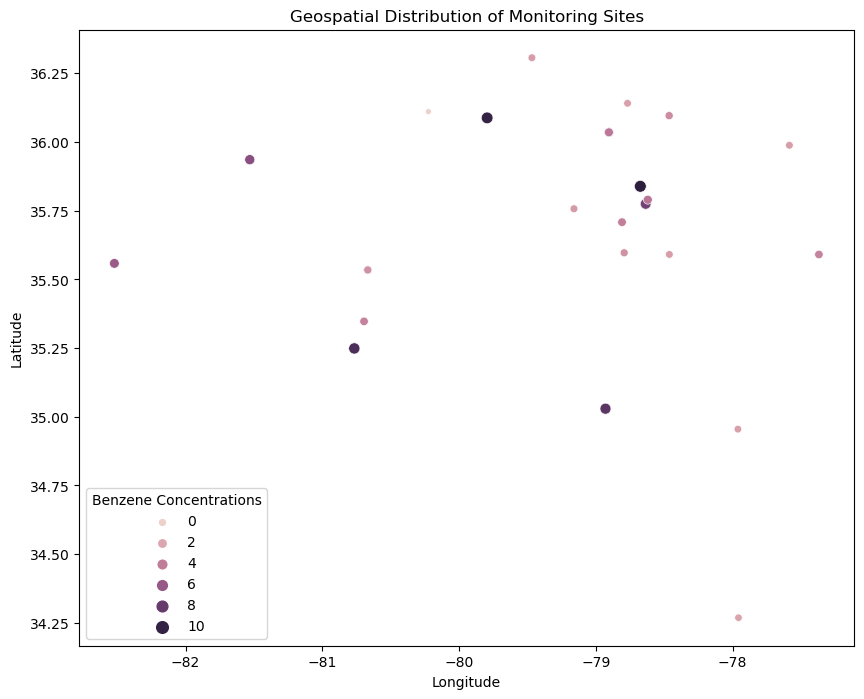

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', size='arithmetic_mean', hue='arithmetic_mean', data=df)
plt.title('Geospatial Distribution of Monitoring Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Benzene Concentrations')
plt.show()


Benzene concentrations in different parts of the state based on the latitude and longitude.

C:\Users\choks\AppData\Local\Temp\ipykernel_64508\1847804538.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dfc.corr()


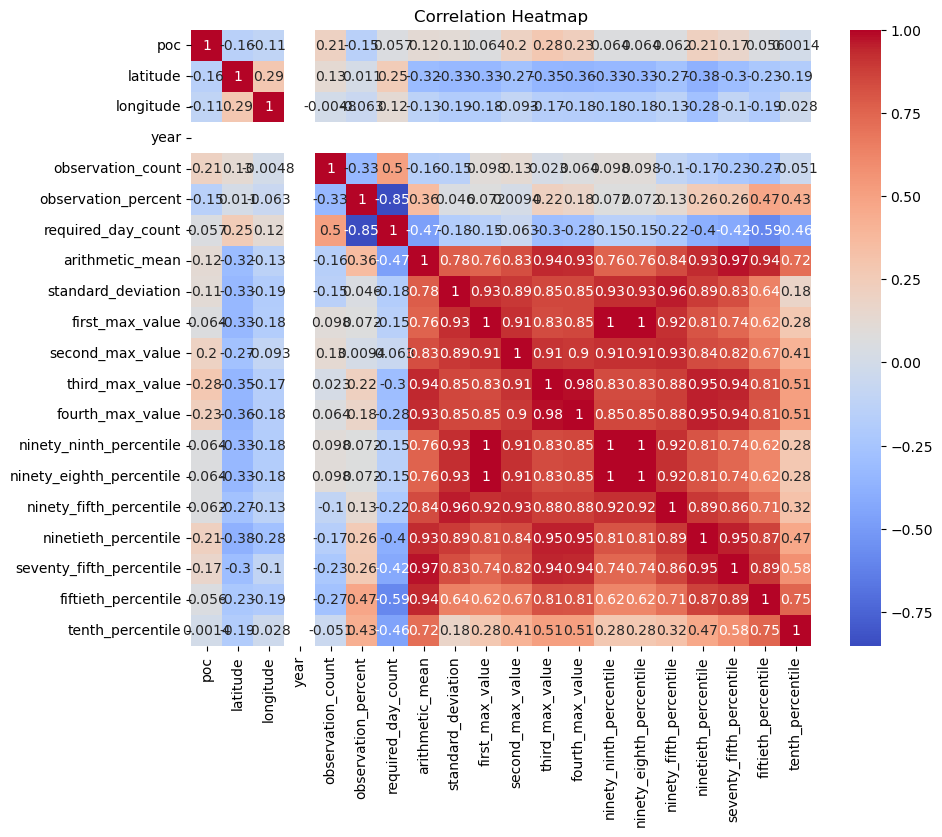

In [31]:
plt.figure(figsize=(10, 8))
correlation_matrix = dfc.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The above plot shows the correlation of different variables of the dataframe, which can be used to determine the pollution and also help in determining ways to reduce it.

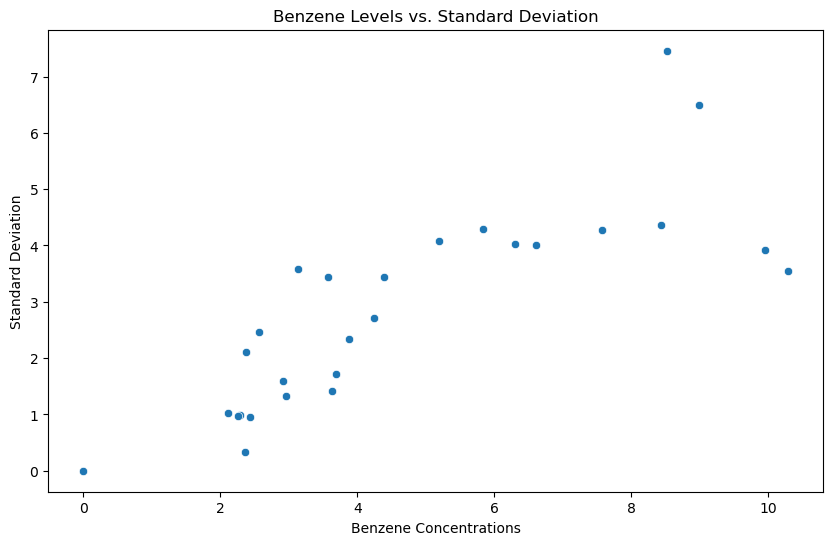

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='arithmetic_mean', y='standard_deviation', data=df)
plt.title('Benzene Levels vs. Standard Deviation')
plt.xlabel('Benzene Concentrations')
plt.ylabel('Standard Deviation')
plt.show()

The above plot helps in understanding the variability in Benzene levels and whether higher concentrations are associated with greater dispersion as each point on the plot represents a specific monitoring site or instance.

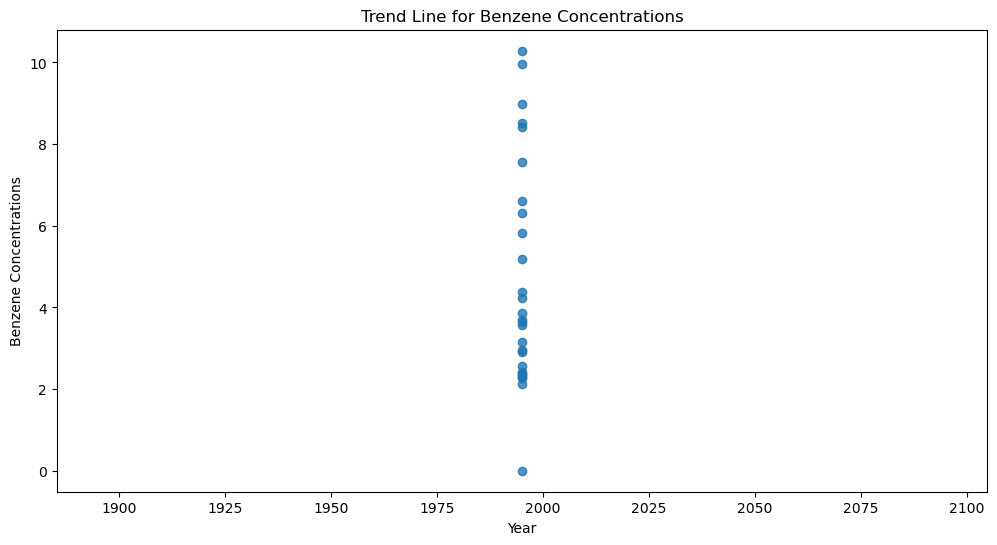

In [33]:
plt.figure(figsize=(12, 6))
sns.regplot(x='year', y='arithmetic_mean', data=df)
plt.title('Trend Line for Benzene Concentrations')
plt.xlabel('Year')
plt.ylabel('Benzene Concentrations')
plt.show()

The overall trend of the above plot shows a decrease in benzene concentration over time. This is a positive finding.

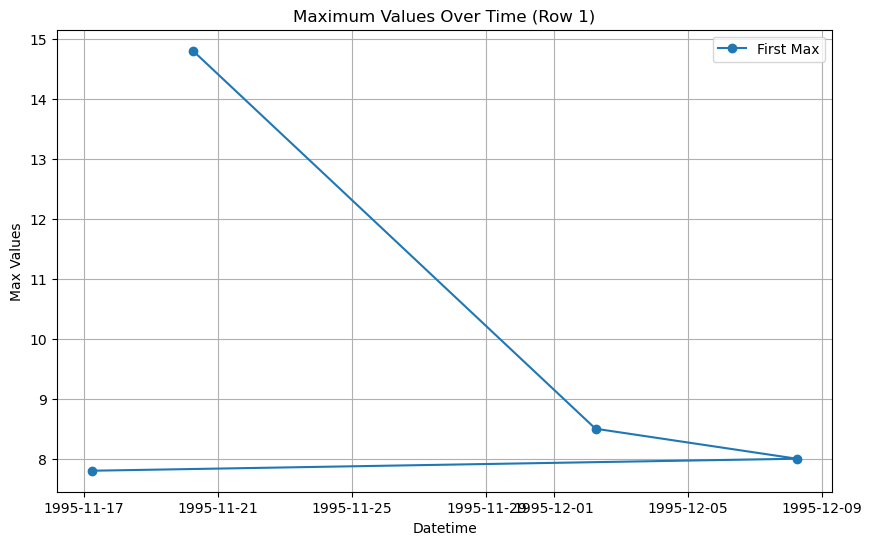

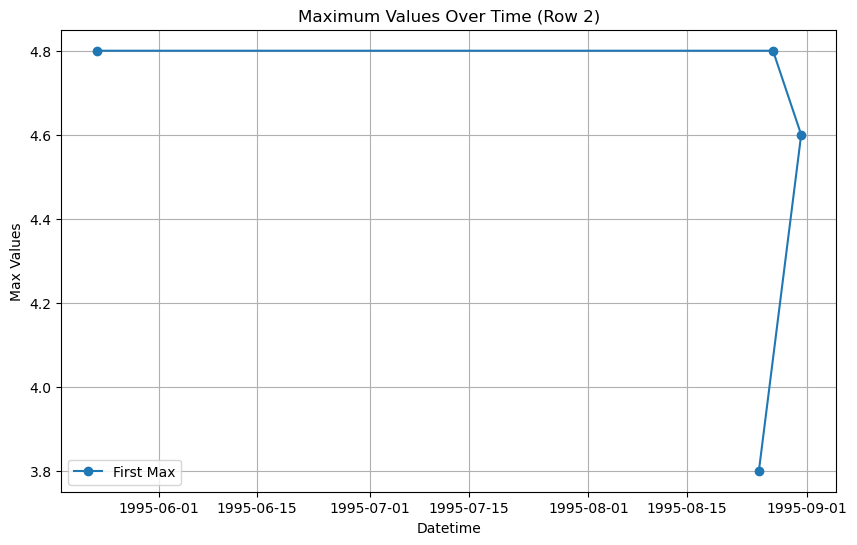

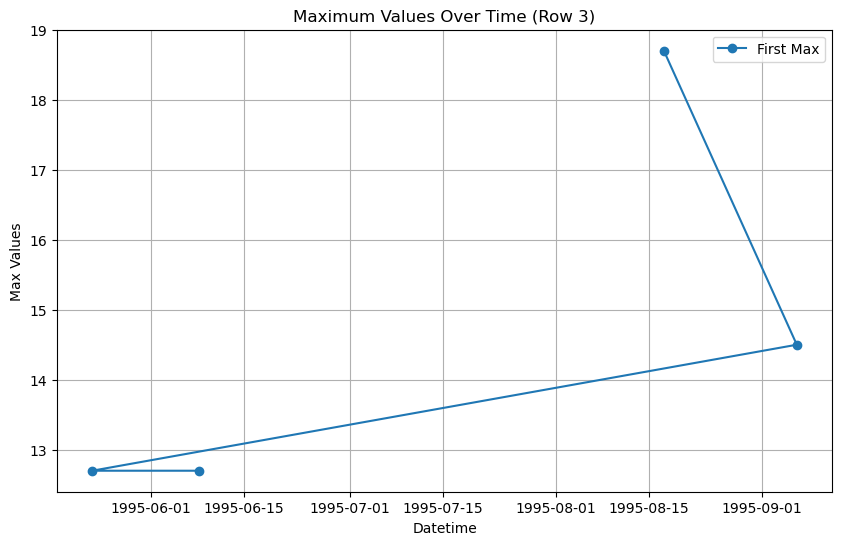

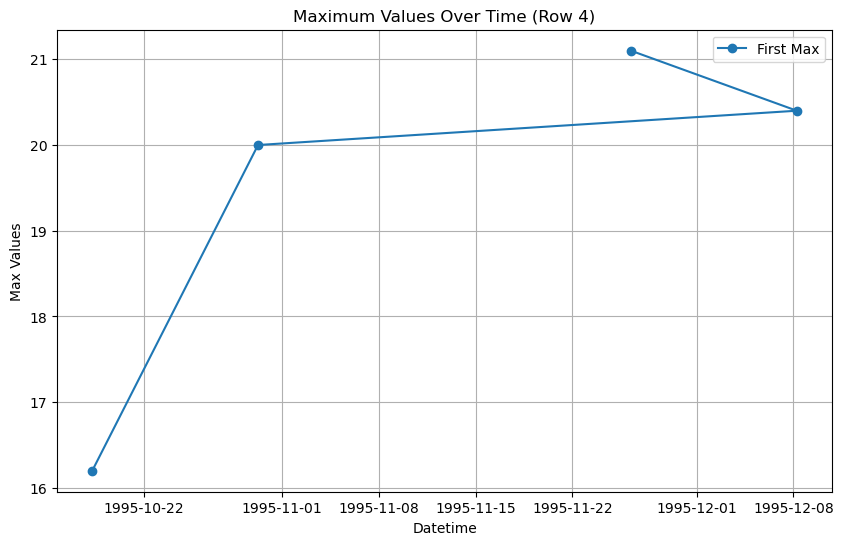

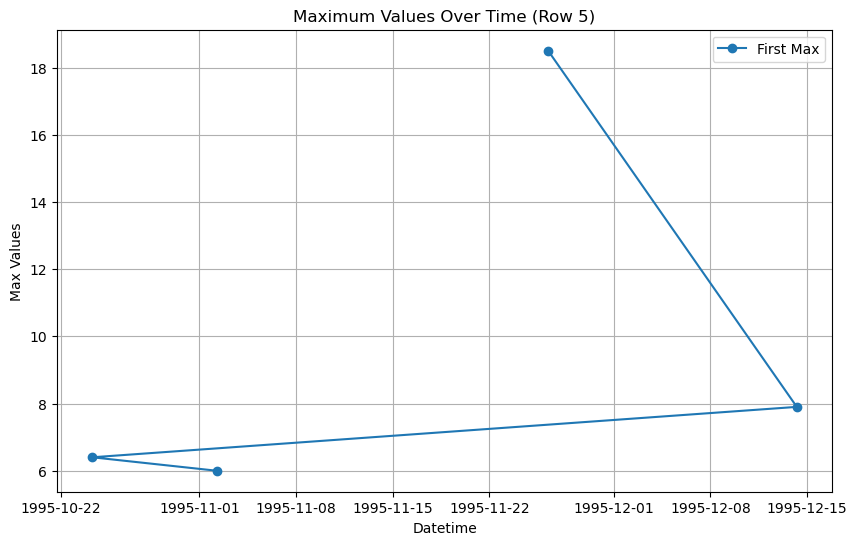

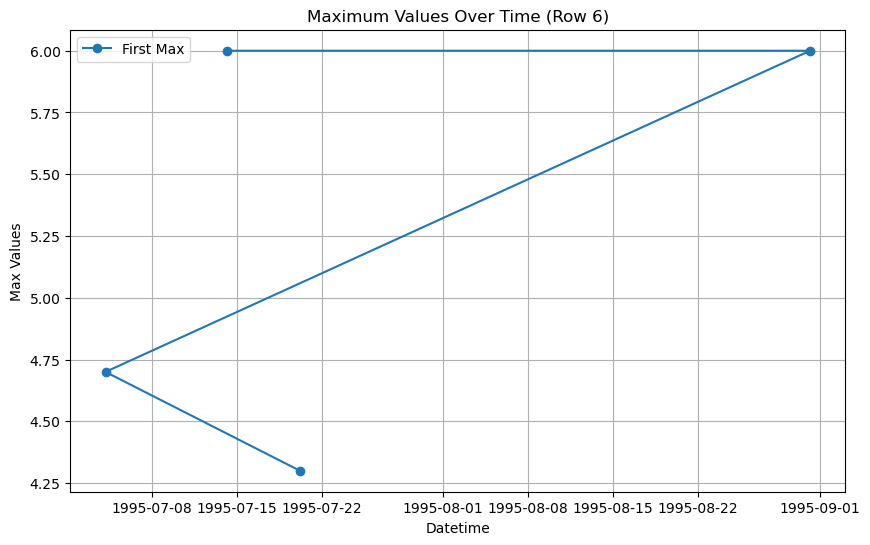

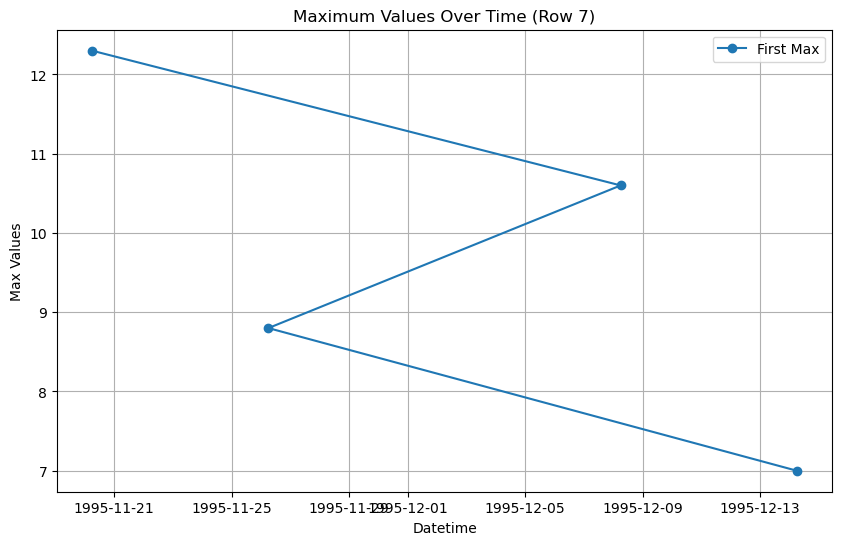

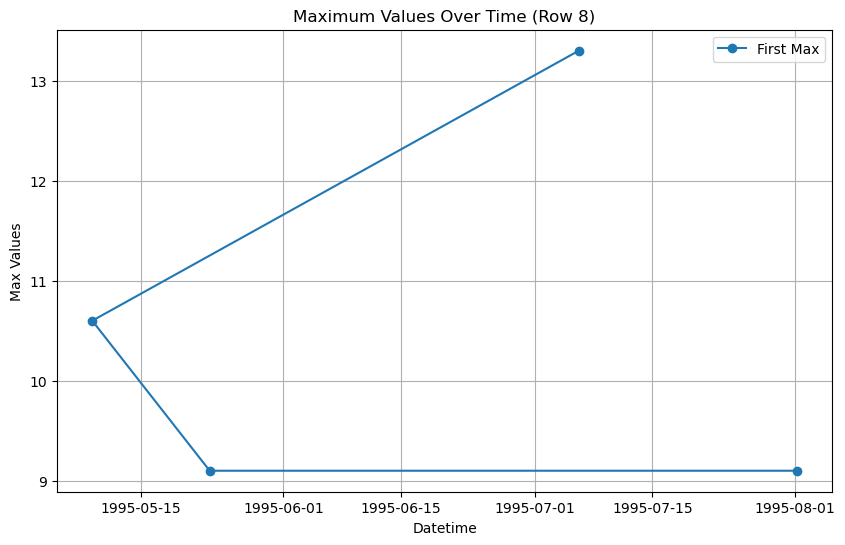

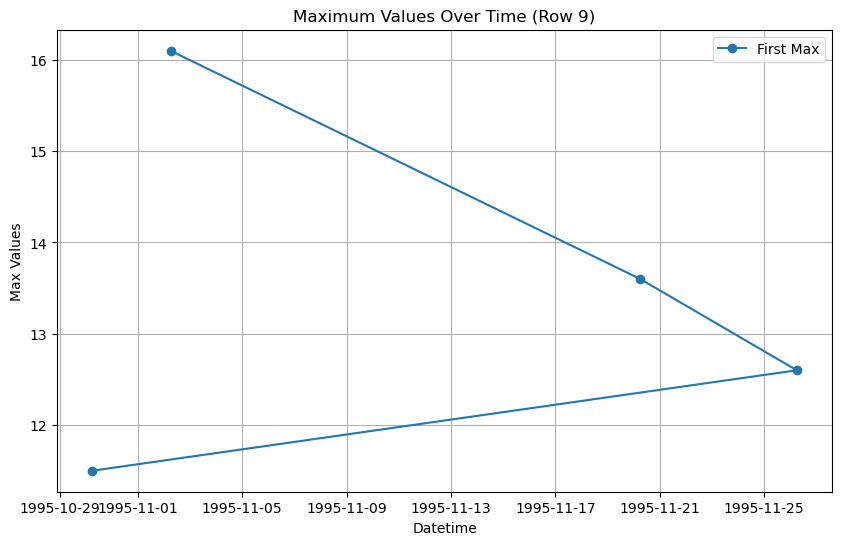

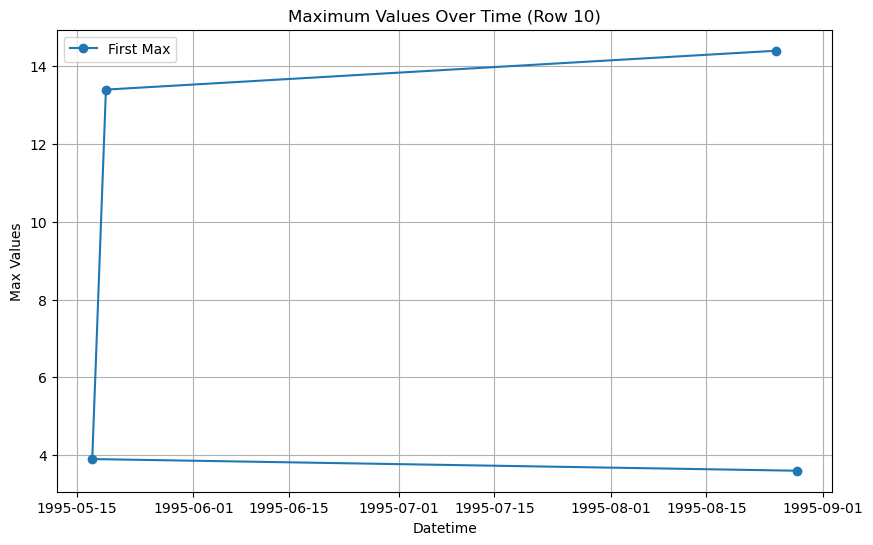

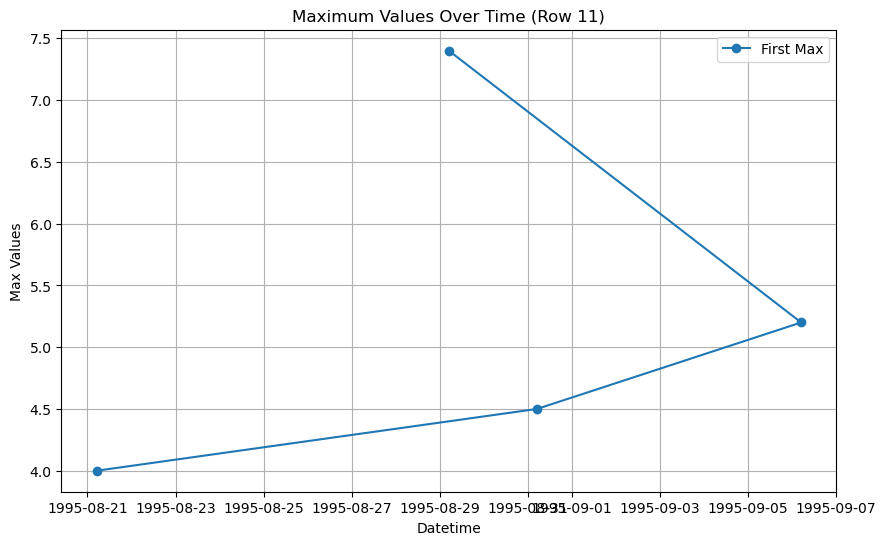

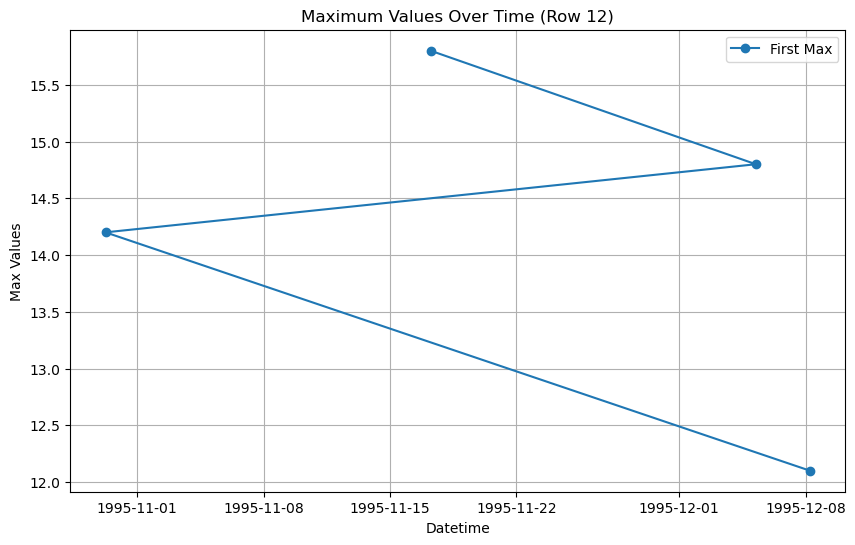

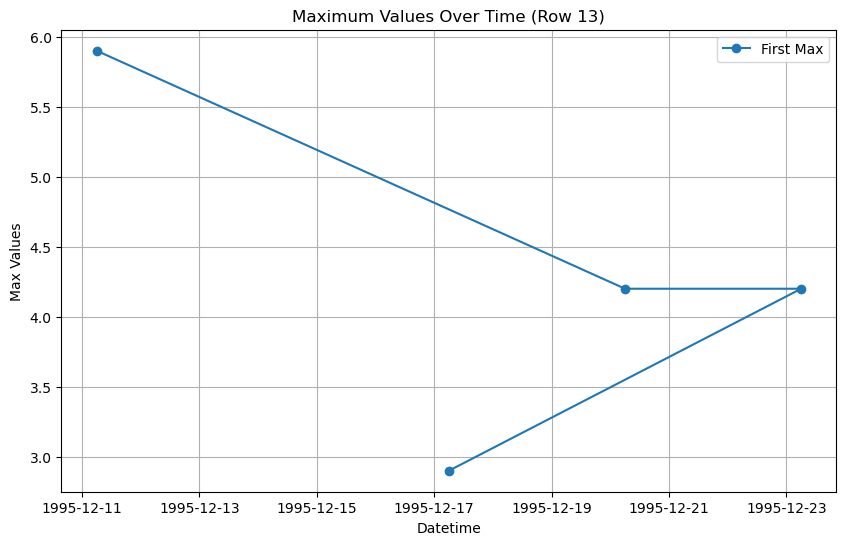

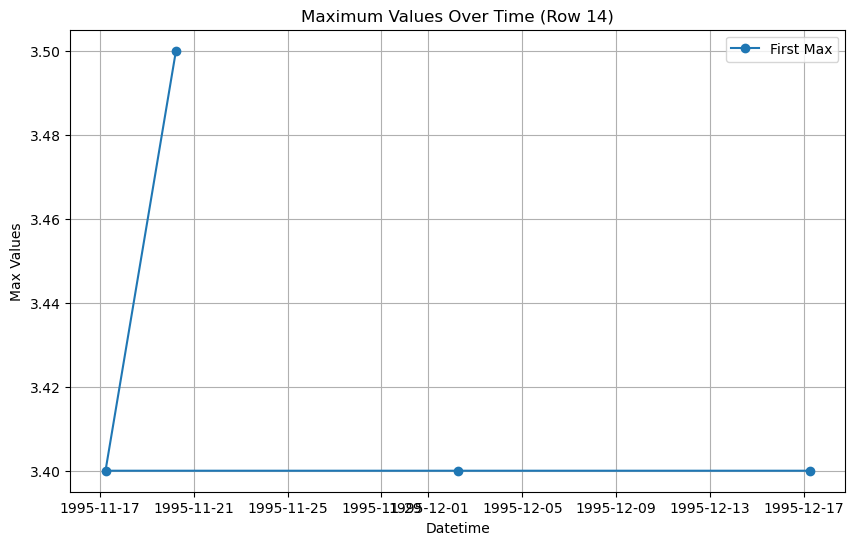

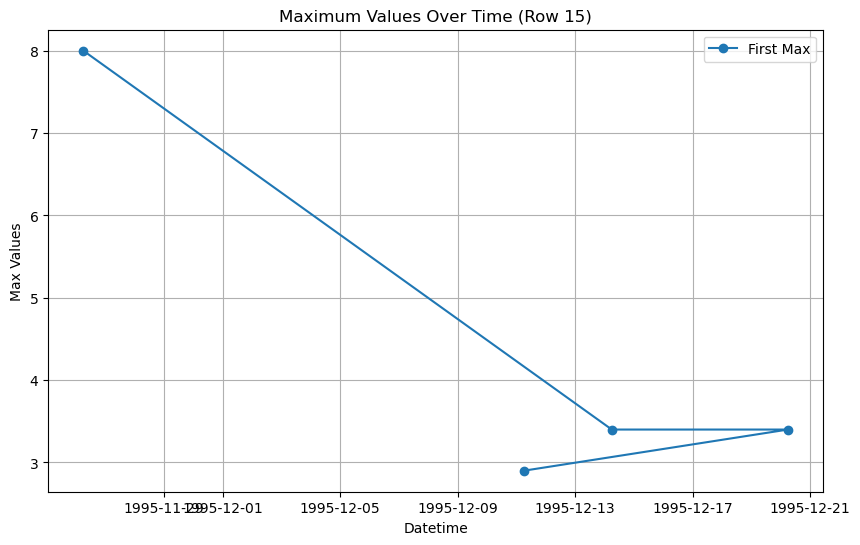

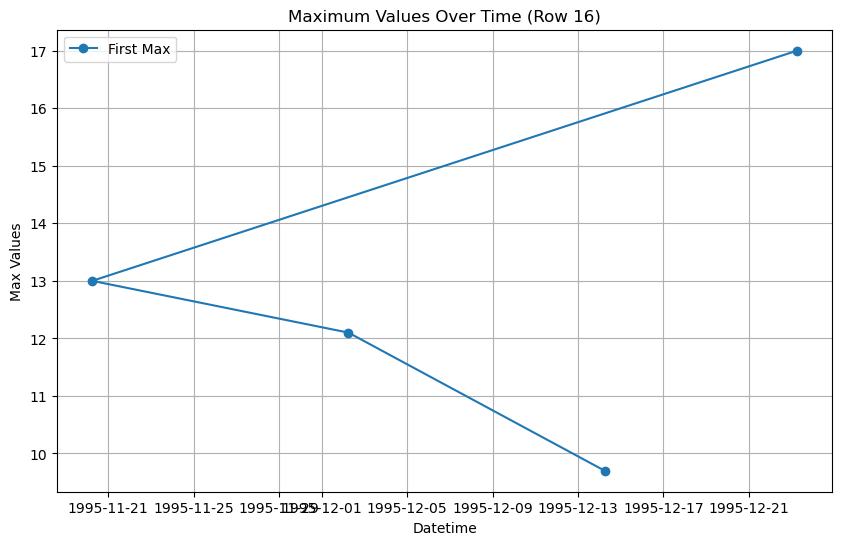

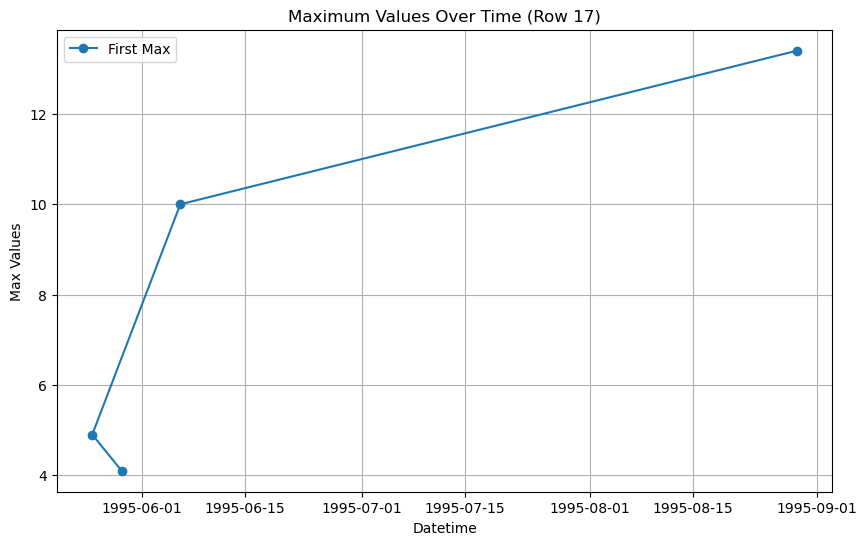

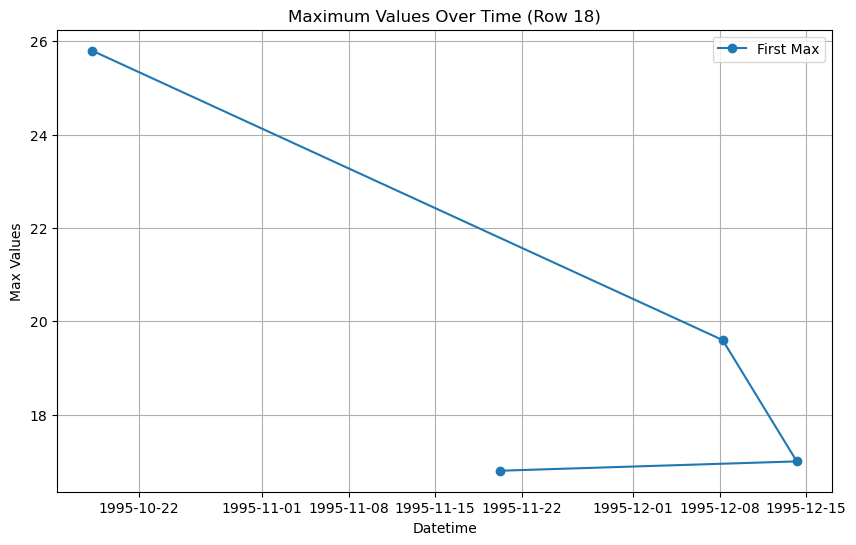

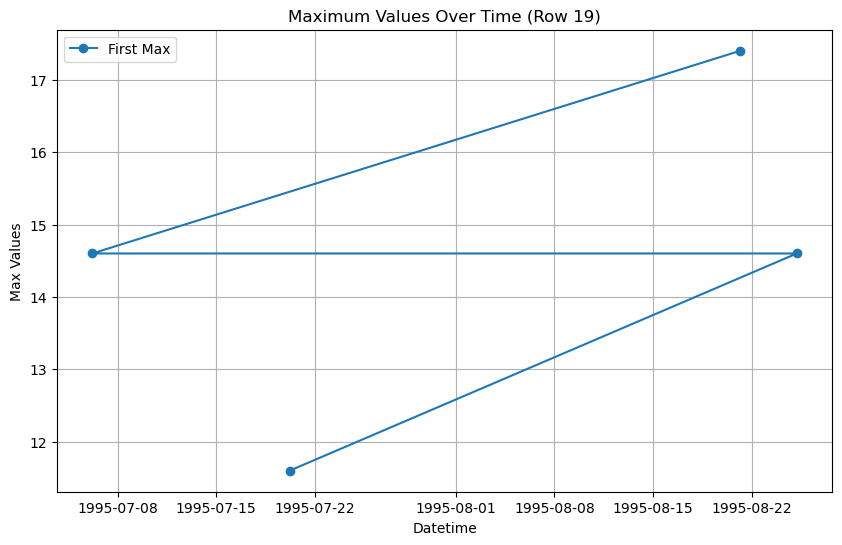

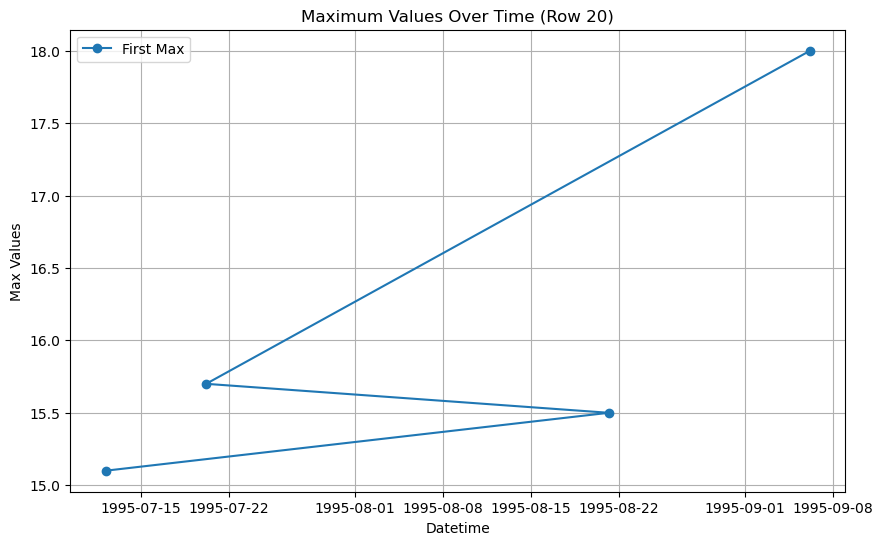

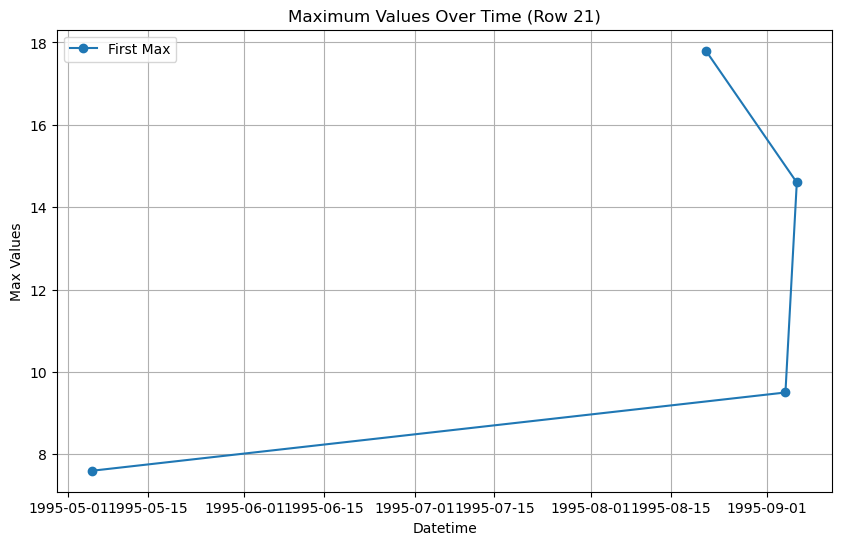

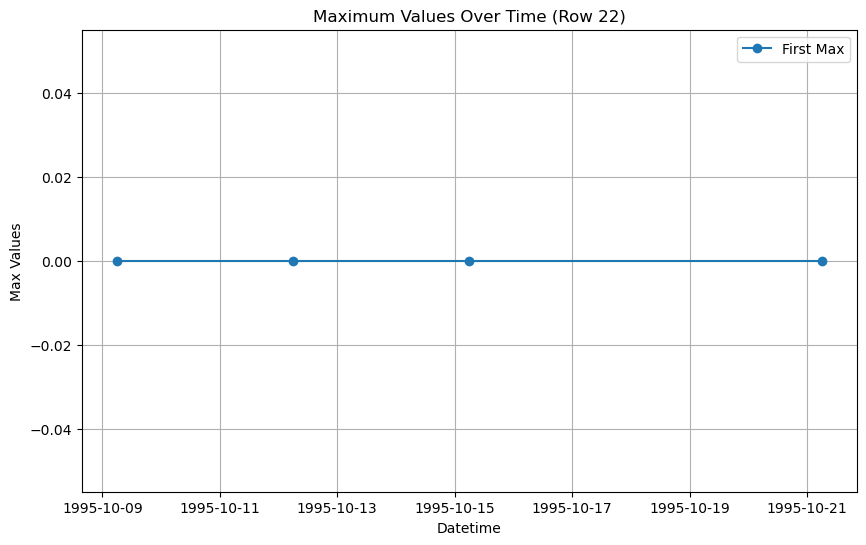

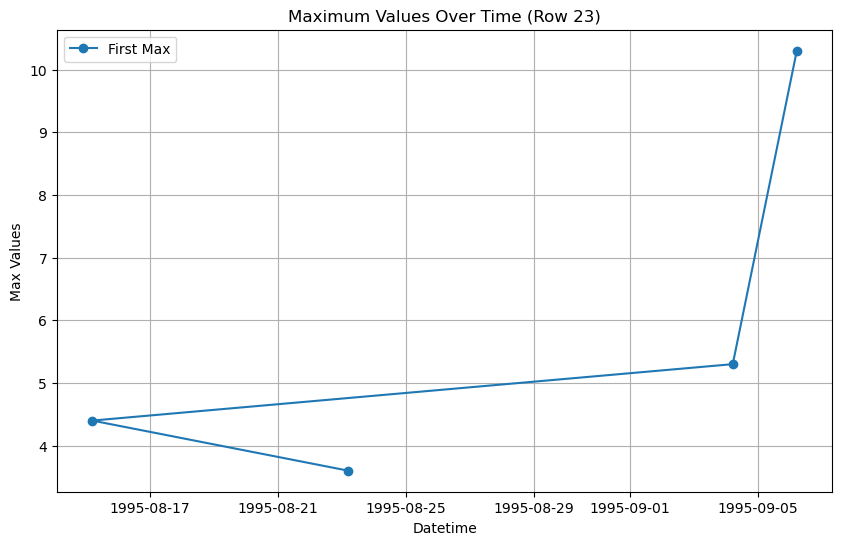

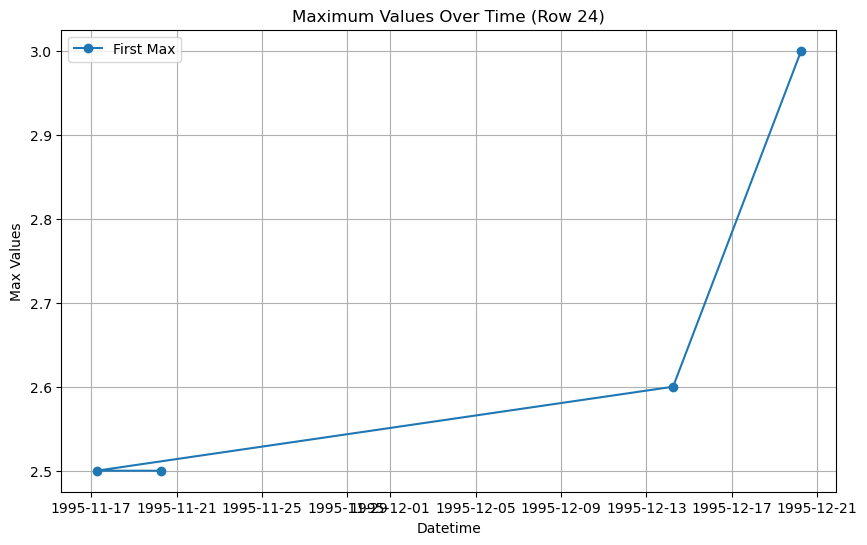

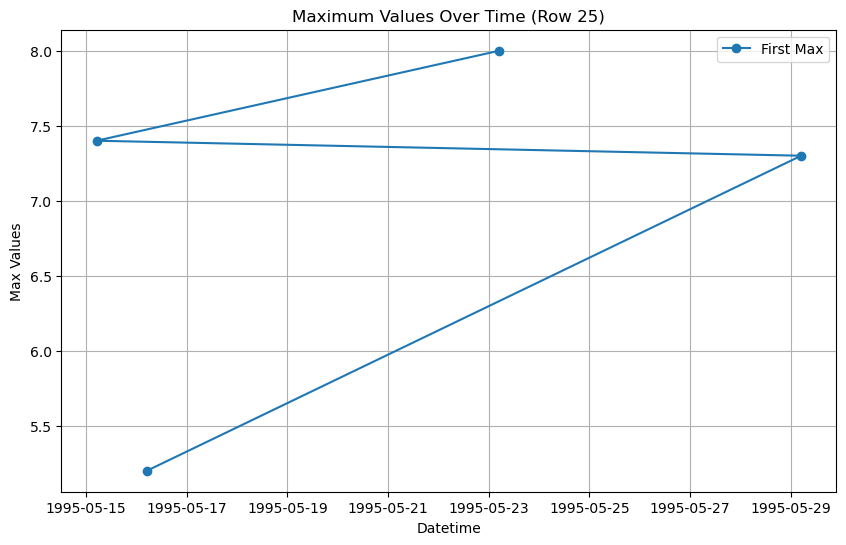

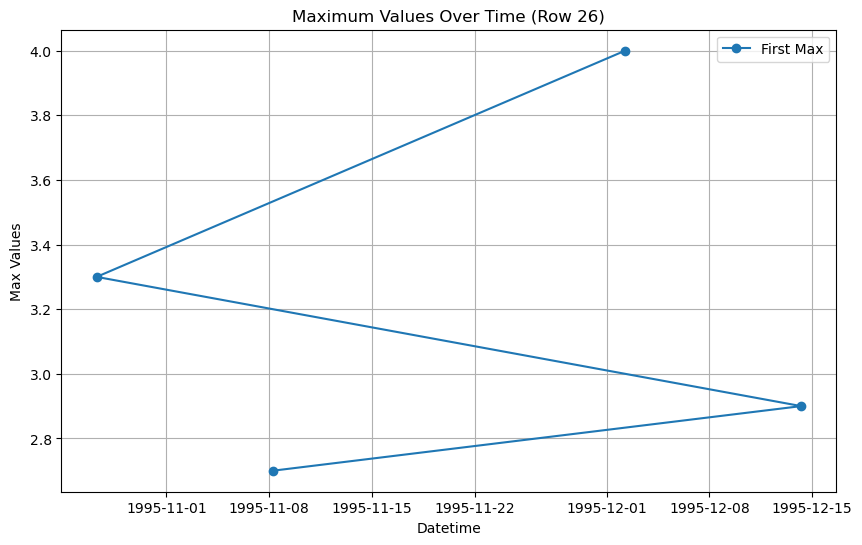

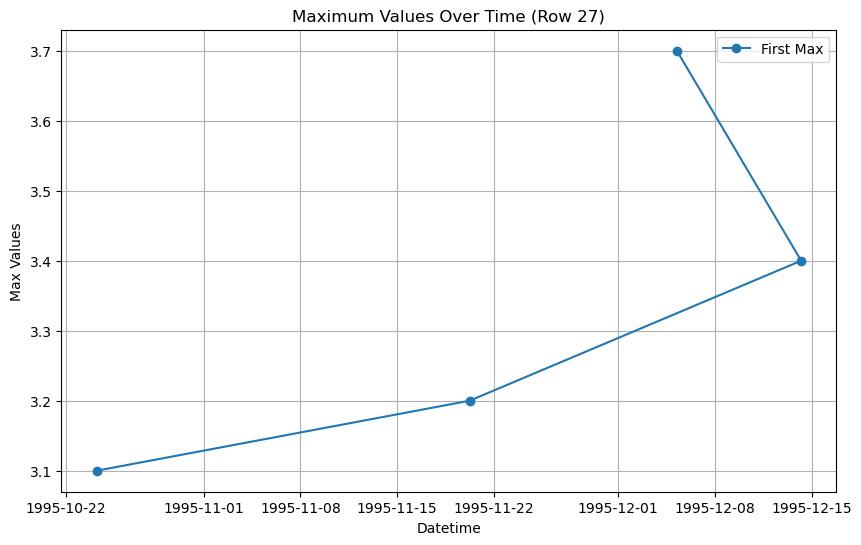

In [34]:
datetime_columns = ['first_max_datetime', 'second_max_datetime', 'third_max_datetime', 'fourth_max_datetime']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

for i in range(1, len(datetime_columns)):
    df[f'time_diff_{i}'] = df[datetime_columns[i]] - df[datetime_columns[i - 1]]

for index, row in df.iterrows():
    plt.figure(figsize=(10, 6))
    plt.plot(row[datetime_columns], row[['first_max_value', 'second_max_value', 'third_max_value', 'fourth_max_value']], marker='o')
    plt.title(f'Maximum Values Over Time (Row {index + 1})')
    plt.xlabel('Datetime')
    plt.ylabel('Max Values')
    plt.legend(['First Max', 'Second Max', 'Third Max', 'Fourth Max'])
    plt.grid(True)
    plt.show()

The above plot shows how Benzene concentration changes over time at a specific monitoring site.

## Clustering:

In [35]:
print(dfc.columns)

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'metric_used', 'method', 'year', 'units_of_measure',
       'event_type', 'observation_count', 'observation_percent',
       'required_day_count', 'arithmetic_mean', 'standard_deviation',
       'first_max_value', 'first_max_datetime', 'second_max_value',
       'second_max_datetime', 'third_max_value', 'third_max_datetime',
       'fourth_max_value', 'fourth_max_datetime', 'ninety_ninth_percentile',
       'ninety_eighth_percentile', 'ninety_fifth_percentile',
       'ninetieth_percentile', 'seventy_fifth_percentile',
       'fiftieth_percentile', 'tenth_percentile', 'site_address', 'state',
       'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')


In [36]:
dfc.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,seventy_fifth_percentile,fiftieth_percentile,tenth_percentile,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,37,021,0032,45201,1,35.558333,-82.520833,WGS84,Benzene,3,...,8.0,7.7,1.8,LONDON RD ASHVILLE NC 28803,North Carolina,Buncombe,Asheville,11700,"Asheville, NC",2020-05-21
1,37,077,0001,45201,1,36.141111,-78.768056,WGS84,Benzene,B,...,2.9,2.0,1.3,800 Central Avenue,North Carolina,Granville,Butner,37080,"Oxford, NC",2020-05-21
2,37,119,0034,45201,1,35.248754,-80.766181,WGS84,Benzene,B,...,7.9,6.0,2.1,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
3,37,119,0034,45201,2,35.248754,-80.766181,WGS84,Benzene,3,...,14.6,6.4,1.7,PLAZA ROAD AND LAKEDELL,North Carolina,Mecklenburg,Charlotte,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21
4,37,159,0022,45201,1,35.534482,-80.667560,WGS84,Benzene,3,...,3.6,2.7,1.0,925 N ENOCHVILLE AVE,North Carolina,Rowan,China Grove,16740,"Charlotte-Concord-Gastonia, NC-SC",2020-05-21


### K-Means, Elbow and Silhouette

In [37]:
d = dfc[['latitude', 'longitude', 'arithmetic_mean']]
d.head()

,latitude,longitude,arithmetic_mean
0,35.558333,-82.520833,5.830000
1,36.141111,-78.768056,2.285366
2,35.248754,-80.766181,6.302703
3,35.248754,-80.766181,8.986957
4,35.534482,-80.667560,3.566667


In [38]:
inertia = []

In [39]:
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(d)
    inertia.append(kmeans.inertia_)

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

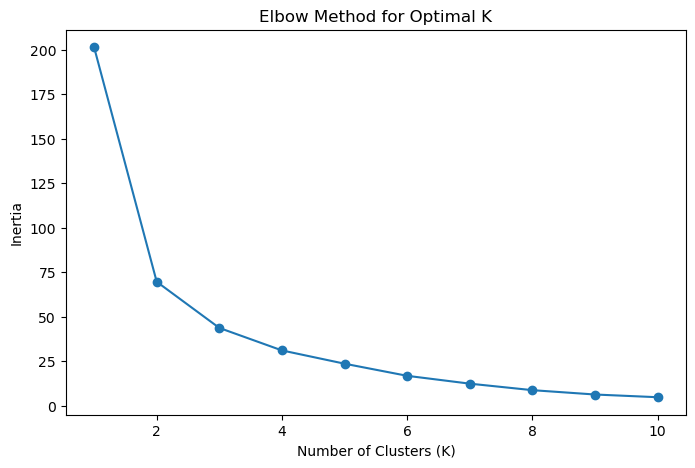

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [42]:
crange = range(2, 11)
scores = []

for num_clusters in crange:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(d)
    
    values = silhouette_samples(d, kmeans.labels_)
    
    average_score = silhouette_score(d, kmeans.labels_)
    
    scores.append(average_score)

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

In [43]:
scores

[0.5373567994923705,
 0.5022043220926108,
 0.4401041780665577,
 0.4358902296697211,
 0.4750399281435352,
 0.42470198716969226,
 0.442545869045189,
 0.43977868567028366,
 0.39718819722906823]

In [44]:
average_score

0.39718819722906823

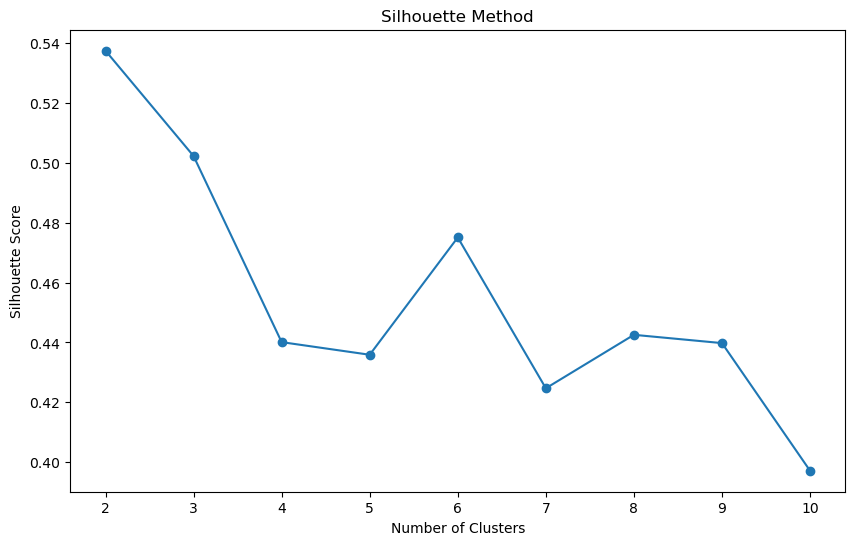

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(crange, scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [47]:
#kmeans = KMeans(n_clusters=3).fit(dfc[['latitude', 'longitude', 'arithmetic_mean']])
kmeans = KMeans(n_clusters=2).fit(d)
d['kmeans_cluster'] = kmeans.labels_

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\choks\AppData\Local\Temp\ipykernel_64508\2181919726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['kmeans_cluster'] = kmeans.labels_


In [48]:
kmeans

KMeans(n_clusters=2)

In [49]:
d['kmeans_cluster']

0     0
1     1
2     0
3     0
4     1
5     1
6     1
7     1
8     0
9     1
10    1
11    0
12    1
14    1
15    0
16    1
17    0
18    0
19    0
20    1
21    1
Name: kmeans_cluster, dtype: int32

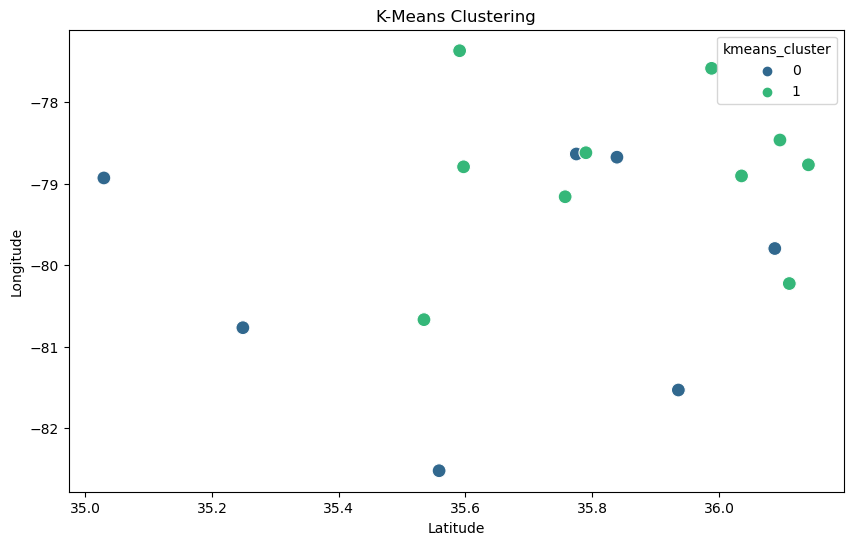

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d, palette='viridis', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [52]:
print(d[['latitude', 'longitude', 'arithmetic_mean', 'kmeans_cluster']])

     latitude  longitude  arithmetic_mean  kmeans_cluster
0   35.558333 -82.520833         5.830000               0
1   36.141111 -78.768056         2.285366               1
2   35.248754 -80.766181         6.302703               0
3   35.248754 -80.766181         8.986957               0
4   35.534482 -80.667560         3.566667               1
5   35.534482 -80.667560         2.960870               1
6   36.035556 -78.904167         5.190909               1
7   36.035556 -78.904167         4.237500               1
8   35.029403 -78.929234         8.427273               0
9   36.096189 -78.463719         3.140909               1
10  35.596944 -78.792500         2.910526               1
11  36.088072 -79.794733         9.958333               0
12  35.590717 -77.368298         3.633333               1
14  35.988278 -77.584300         2.375000               1
15  35.935900 -81.530600         6.610526               0
16  35.757222 -79.159722         2.569444               1
17  35.774875 

In [53]:
print(d['kmeans_cluster'].value_counts())


1    12
0     9
Name: kmeans_cluster, dtype: int64


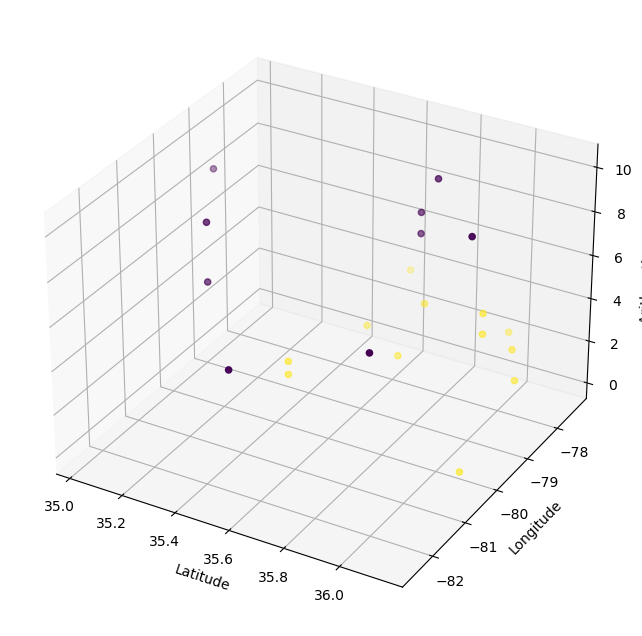

In [55]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d['latitude'], d['longitude'], d['arithmetic_mean'], c=d['kmeans_cluster'], marker='o')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Arithmetic Mean')
plt.show()


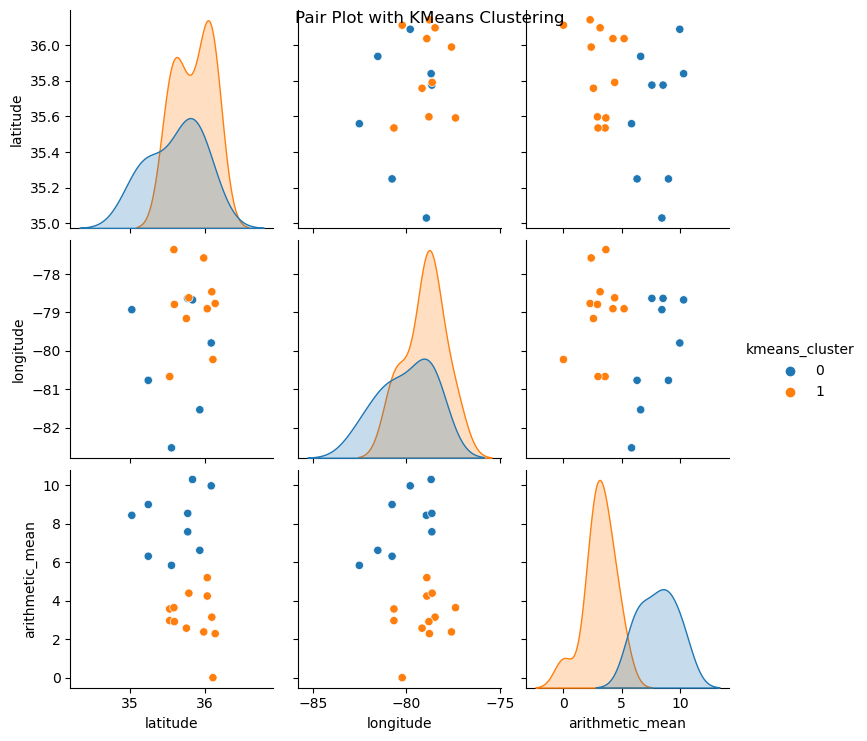

In [56]:
sns.pairplot(d, hue='kmeans_cluster', diag_kind='kde')
plt.show()


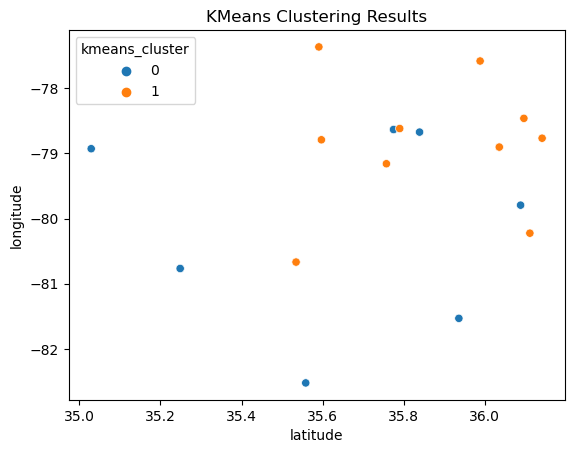

In [57]:
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d)
plt.title('KMeans Clustering Results')
plt.show()

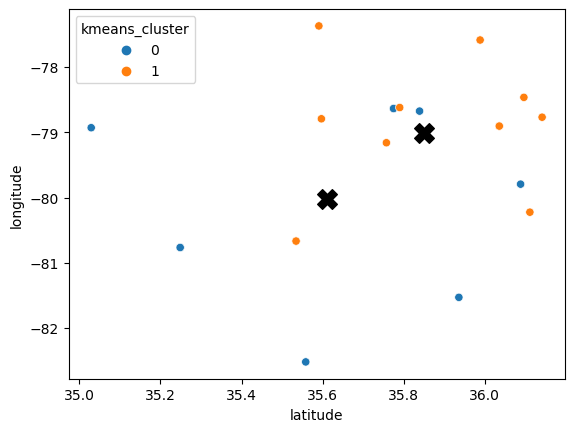

In [58]:
centroids = kmeans.cluster_centers_
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='black', label='Centroids')
plt.show()

In [59]:
centroids

array([[ 35.61088267, -80.028067  ,   8.05580911],
       [ 35.85095833, -79.01035608,   3.10475083]])

In [60]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(d)
d['dbscan_cluster'] = dbscan.labels_

C:\Users\choks\AppData\Local\Temp\ipykernel_64508\4146417925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['dbscan_cluster'] = dbscan.labels_


In [61]:
d['dbscan_cluster']

0    -1
1    -1
2    -1
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10   -1
11   -1
12   -1
14   -1
15   -1
16   -1
17   -1
18   -1
19   -1
20   -1
21   -1
Name: dbscan_cluster, dtype: int64

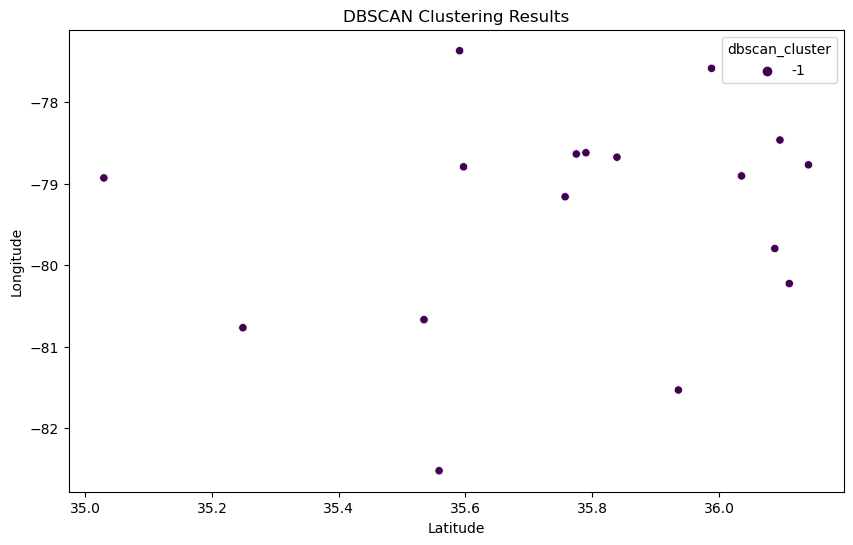

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='longitude', hue='dbscan_cluster', data=d, palette='viridis', legend='full')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

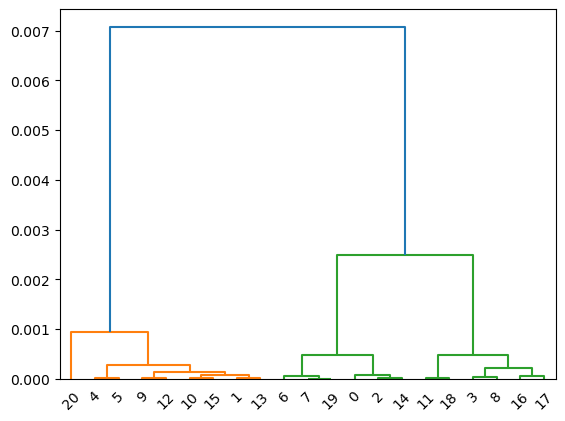

In [63]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(d, method='complete', metric='cosine'))